# Multimodal Factorization Model - CMU-MOSEI Dataset

In [5]:
import pickle

with open('mosei_raw.pkl', 'rb') as file:
    data = pickle.load(file)

print(type(data))  # 查看内容类型
print(data["train"]["labels"][0])

<class 'dict'>
[[1.        0.6666667 0.6666667 0.        0.        0.        0.6666667]]


## Importing Libraries

In [1]:
import sys
import torch
import matplotlib.pyplot as plt

# sys.path.append('/workspace/rongchuan/ipynb/Multimodal-Emotion-Recognition/src')

## Importing Helper Functions

In [2]:
from loader import get_dataloader
from unimodals.modules import MLP
from unimodals.MVAE import TSEncoder, TSDecoder
from unimodals.modules import Sequential2
from objectives import MFM_objective
from training.supervised import train, test
from fusions.modules import Concat
from utils import get_default_device, save_results

## Loading the Dataset

In [3]:
classes = 2
n_latent = 256
dim_0 = 35
dim_1 = 74
dim_2 = 300
timestep = 50
train_data, valid_data, test_data = get_dataloader(
    "mosei_senti_data.pkl",
    task="classification",
    max_pad=True,
    max_seq_len=timestep
)

In [4]:
device = get_default_device()

## Model Architecture

In [5]:
encoders = [
    TSEncoder(dim_0, 30, n_latent, timestep, returnvar=False).to(device),
    TSEncoder(dim_1, 30, n_latent, timestep, returnvar=False).to(device),
    TSEncoder(dim_2, 30, n_latent, timestep, returnvar=False).to(device),
]

decoders = [
    TSDecoder(dim_0, n_latent, timestep).to(device),
    TSDecoder(dim_1, n_latent, timestep).to(device),
    TSDecoder(dim_2, n_latent, timestep).to(device),
]

fuse = Sequential2(Concat(), MLP(3 * n_latent, n_latent, n_latent // 2)).to(
    device
)

intermediates = [
    MLP(n_latent, n_latent // 2, n_latent // 2).to(device),
    MLP(n_latent, n_latent // 2, n_latent // 2).to(device),
    MLP(n_latent, n_latent // 2, n_latent // 2).to(device),
]

head = MLP(n_latent // 2, 20, classes).to(device)

argsdict = {"decoders": decoders, "intermediates": intermediates}

additional_modules = decoders + intermediates

objective = MFM_objective(
    2.0,
    [torch.nn.MSELoss(), torch.nn.MSELoss(), torch.nn.MSELoss()],
    [1.0, 1.0, 1.0],
)

## Training

In [6]:
OUTPUT_MODEL_FILE_NAME = "mosei_Multimodal_Factorization_Model"

train_losses, valid_losses = train(
    encoders,
    fuse,
    head,
    train_data,
    valid_data,
    200,
    additional_modules,
    objective=objective,
    objective_args_dict=argsdict,
    save=f"content/{OUTPUT_MODEL_FILE_NAME}.pt",
)

Epoch [1/200]
Train Loss: 90.0550
Valid Loss: 57.4981 | Accuracy: 49.8127%
Saving Best

Epoch [2/200]
Train Loss: 60.1940
Valid Loss: 40.4721 | Accuracy: 50.1873%
Saving Best

Epoch [3/200]
Train Loss: 51.0872
Valid Loss: 75.3067 | Accuracy: 50.1873%

Epoch [4/200]
Train Loss: 44.4491
Valid Loss: 47.5424 | Accuracy: 50.1873%

Epoch [5/200]
Train Loss: 40.6240
Valid Loss: 41.6647 | Accuracy: 52.1134%
Saving Best

Epoch [6/200]
Train Loss: 37.1903
Valid Loss: 43.5288 | Accuracy: 57.0358%
Saving Best

Epoch [7/200]
Train Loss: 39.7463
Valid Loss: 47.1837 | Accuracy: 54.5211%

Epoch [8/200]
Train Loss: 40.2589
Valid Loss: 22.2407 | Accuracy: 55.9123%

Epoch [9/200]
Train Loss: 33.4513
Valid Loss: 23.9577 | Accuracy: 56.8218%

Epoch [10/200]
Train Loss: 30.7817
Valid Loss: 20.8674 | Accuracy: 56.3938%

Epoch [11/200]
Train Loss: 27.5453
Valid Loss: 20.7075 | Accuracy: 53.6116%

Epoch [12/200]
Train Loss: 26.7380
Valid Loss: 51.8636 | Accuracy: 54.7887%

Epoch [13/200]
Train Loss: 25.4426
Va

Text(0.5, 1.0, 'Loss vs. No. of epochs')

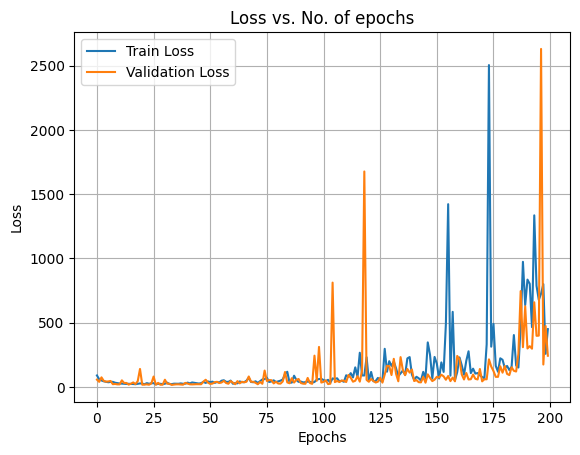

In [7]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [8]:
save_results(train_losses, valid_losses, f'content/{OUTPUT_MODEL_FILE_NAME}.pkl')

## Testing

model = torch.load(f"content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)

test(
    model,
    test_dataloaders_all=test_data,
    is_packed=False
)
